In this notebook we examine whether the G3 compartment represents only the walking/paused state of the fly, or whether it contains information about the fine-scale walking speed of the fly as well.

# Classify walking/paused states using G3

Here we fit a logistic regression classifier to predict the walking ('W') or paused ('P') states for each trial with labeled states.

In [1]:
%reset -f
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression

from aux import make_extended_predictor_matrix, save_table
from data import DataLoader
%aimport lin_fit
from plot import set_font_size

import LOCAL_SETTINGS as L

In [2]:
from db import make_session, d_models

FILT = [d_models.Trial.walking_threshold != None]

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

In [3]:
closed_mask = [trial.expt == 'closed_loop' for trial in trials]
driven_mask = [trial.expt == 'driven_random' for trial in trials]
no_air_mask = [trial.expt == 'no_air' for trial in trials]

c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'no_air': 'r'}

In [4]:
for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx=0, vel_filt=None)

Loading data for trial 1/44 (20170310.Fly2.6)
Loading clean data from file "clean_0.csv"...
Loading data for trial 2/44 (20170310.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 3/44 (20170310.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 4/44 (20170313.Fly1.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 5/44 (20170313.Fly1.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 6/44 (20170313.Fly1.3)
Loading clean data from file "clean_0.csv"...
Loading data for trial 7/44 (20170313.Fly1.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 8/44 (20170313.Fly1.8)
Loading clean data from file "clean_0.csv"...
Loading data for trial 9/44 (20170313.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 10/44 (20170313.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 11/44 (20170313.Fly3.3)
Loading clean data from file "cl

# Predict walking speed during walking states using G3

In [5]:
WINDOWS = {
    'g2': {'g2s': (-1, 2)},
    'g3': {'g3s': (-1, 2)},
    'g4': {'g4s': (-1, 2)},
    'g5': {'g5s': (-1, 2)},
}

preds = {k: w.keys() for k, w in WINDOWS.items()}
rslts_clf = {'g3': [lin_fit.classify_states(trial, preds['g3'], WINDOWS['g3']) for trial in trials]}

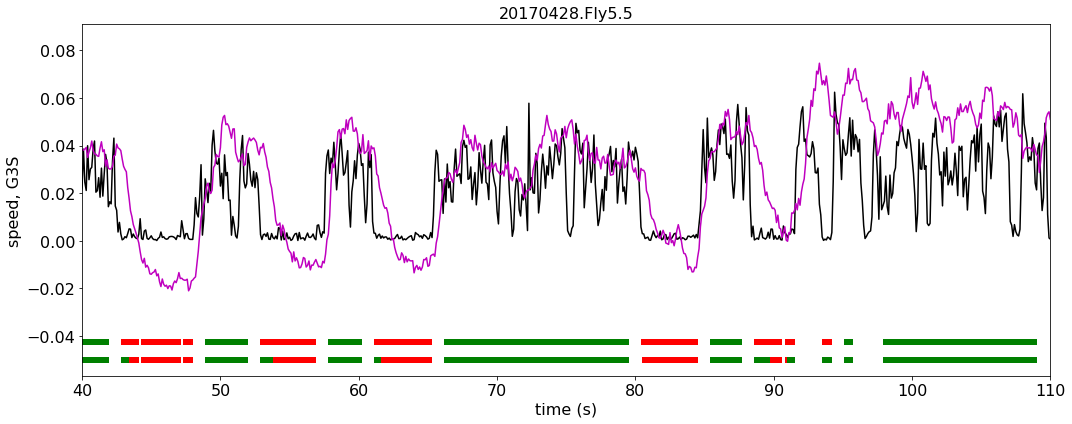

In [6]:
from plot import set_font_size

EXAMPLE = '20170428.Fly5.5'
LINE_YS = [-0.0425, -0.05]
LW = 6

# plot example trial's walking speed, G3S, true state labels, and predicted state labels
trial_idx = [trial.name for trial in trials].index(EXAMPLE)
trial_ex = trials[trial_idx]
rslt_ex = rslts_clf['g3'][trial_idx]

fig, ax = plt.subplots(1, 1, figsize=(15, 6), tight_layout=True)

ts = trial_ex.dl.t
speed = trial_ex.dl.speed
G3S = trial_ex.dl.g3s

# normalize G3S to be plottable atop speed
G3S -= G3S.mean()
G3S /= G3S.std()
G3S *= speed.std()
G3S += speed.mean()

ax.plot(ts, speed, color='k', lw=1.5)
ax.plot(ts, G3S, color='m', lw=1.5)

# plot true state labels, predicted state labels, and 
states_p = np.repeat(np.nan, len(ts))
states_p[rslt_ex.states == 'P'] = LINE_YS[0]
states_w = np.repeat(np.nan, len(ts))
states_w[rslt_ex.states == 'W'] = LINE_YS[0]

states_p_pred = np.repeat(np.nan, len(ts))
states_p_pred[rslt_ex.states_pred == 'P'] = LINE_YS[1]
states_w_pred = np.repeat(np.nan, len(ts))
states_w_pred[rslt_ex.states_pred == 'W'] = LINE_YS[1]

ax.plot(ts, states_p, lw=LW, color='r')
ax.plot(ts, states_w, lw=LW, color='g')

ax.plot(ts, states_p_pred, lw=LW, color='r')
ax.plot(ts, states_w_pred, lw=LW, color='g')

ax.set_xlim(40, 110)

ax.set_xlabel('time (s)')
ax.set_ylabel('speed, G3S')
ax.set_title(EXAMPLE)

set_font_size(ax, 16)

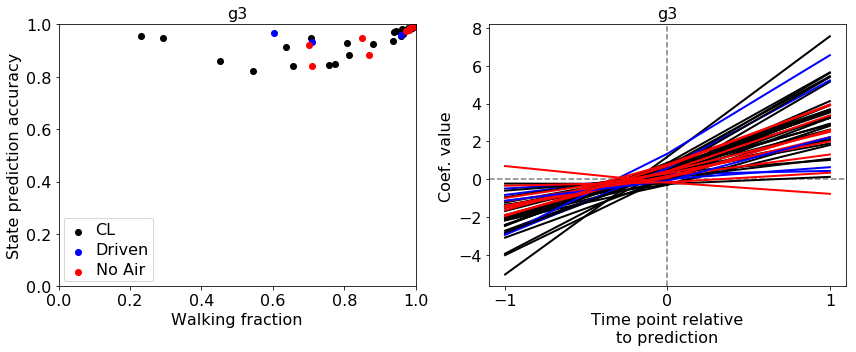

In [7]:
def plot_state_classifications(key, coef, axs):

    walk_fracs = np.array([r.walk_frac for r in rslts_clf[key]])
    accs = np.array([r.acc for r in rslts_clf[key]])

    c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'no_air': 'r'}

    axs[0].scatter(walk_fracs[closed_mask], accs[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    axs[0].scatter(walk_fracs[driven_mask], accs[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    axs[0].scatter(walk_fracs[no_air_mask], accs[no_air_mask], s=50, c=c_dict['no_air'], lw=0)

    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)

    axs[0].set_xlabel('Walking fraction')
    axs[0].set_ylabel('State prediction accuracy')
    axs[0].set_title(key)
    axs[0].legend(['CL', 'Driven', 'No Air'], loc='best')

    for r, trial in zip(rslts_clf[key], trials):
        c = c_dict[trial.expt]

        if r.coefs is not None:
            axs[1].plot(np.arange(*WINDOWS[key][coef]), r.coefs[coef], color=c, lw=2)

    axs[1].axhline(0, color='gray', ls='--', zorder=-1)
    axs[1].axvline(0, color='gray', ls='--', zorder=-1)

    axs[1].set_xlabel('Time point relative\nto prediction')
    axs[1].set_ylabel('Coef. value')

    axs[1].set_xticks(range(*WINDOWS[key][coef]))
    axs[1].set_title(key)

    for ax in axs.flatten():
        set_font_size(ax, 16)
        
# plot accuracy vs. fraction of time spent walking, and G3S coefs
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
plot_state_classifications('g3', 'g3s', axs)

# Predict walking speed during walking epochs using G3S

In [8]:
def predict_speeds(trial, preds, windows):
    """
    Predict the walking speeds for each trial during the epochs labeled as walking.
    
    :param trial: trial object
    :param windows: dict of windows to use for each predictive dan
        (keys are DAN names, vals are tuples of (start, end) time
            points relative to time point of prediction)
            
    :return: RegressionResult
    """
    states = trial.dl.state
    speed = trial.dl.speed
    vs = {pred: getattr(trial.dl, pred) for pred in preds}
    
    # make extended dan predictor matrix
    vs_extd = make_extended_predictor_matrix(vs, windows, order=preds)
    
    # mark all non-walking speeds with nan
    speed[states != 'W'] = np.nan
    
    # make valid mask (not nan predictors and not nan speed)
    valid = np.all(~np.isnan(vs_extd), axis=1) & (~np.isnan(speed))
    
    if valid.sum() > 0:
        # at least one valid time point
        rgr_rslt = lin_fit.regress(trial, targ='speed', preds=preds, windows=windows, valid=valid)
        
    else:
        # no valid time points
        rgr_rslt = lin_fit.RegressionResult(
            trial_id=trial.id, targ='speed', preds=preds, windows=windows,
            valid=valid, ys=speed, ys_pred=None, coefs=None, rgr=None)
    
    return rgr_rslt

In [9]:
WINDOWS = {
    'g2': {'g2s': (-1, 2)},
    'g3': {'g3s': (-1, 2)},
    'g4': {'g4s': (-1, 2)},
    'g5': {'g5s': (-1, 2)},
}

preds = {k: w.keys() for k, w in WINDOWS.items()}

rslts_rgr = {'g3': [predict_speeds(trial, preds['g3'], WINDOWS['g3']) for trial in trials]}

/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if valid == 'all':
/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:145: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif valid == 'none':


### Plot example trial

In [10]:
def plot_example_speed_prediction(trial_name, key, fig_size=(15, 6), color='m'):

    trial_idx = [trial.name for trial in trials].index(trial_name)
    trial = list(trials)[trial_idx]
    rslt = rslts_rgr[key][trial_idx]

    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

    ts = trial.dl.t
    speed = trial.dl.speed
    states = trial.dl.state

    # plot speed and prediction during walking bouts
    ax.plot(ts, rslt.ys, lw=1, color='k')
    ax.plot(ts, rslt.ys_pred, lw=1, color=color)

    # plot non-walking bout speeds as faint gray lines
    speed_not_walk = speed.copy()
    speed_not_walk[states == 'W'] = np.nan
    ax.plot(ts, speed_not_walk, lw=1.5, alpha=0.3, color='gray')

    ax.set_xlabel('t (s)')
    ax.set_ylabel('speed, {} pred.'.format(key))
    ax.set_title('{0}: R^2 = {1:.4f}'.format(trial_name, rslt.r2))

    set_font_size(ax, 16)
    
    return ax

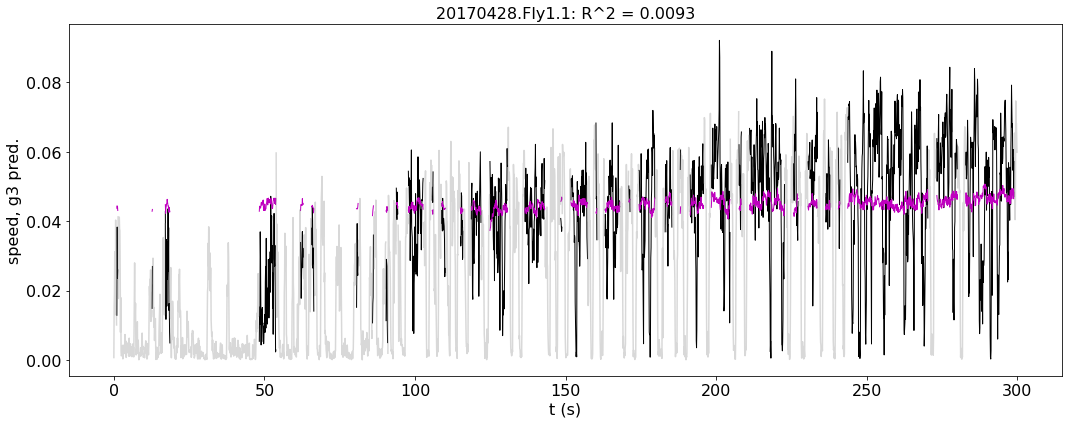

In [11]:
EXAMPLE = '20170428.Fly1.1'
plot_example_speed_prediction(EXAMPLE, 'g3');

(200, 300)

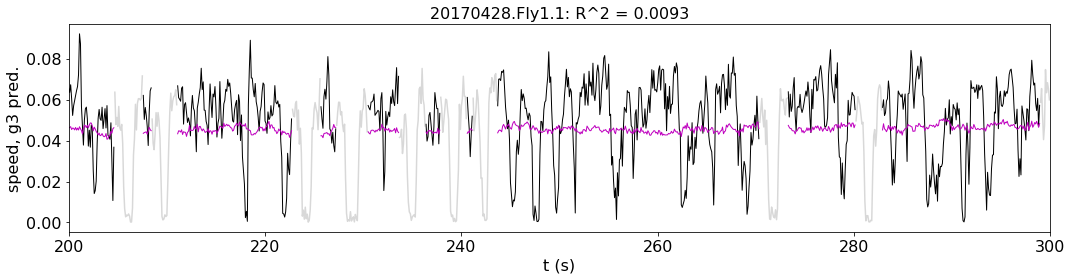

In [12]:
ax = plot_example_speed_prediction(EXAMPLE, 'g3', fig_size=(15, 4))
ax.set_xlim(200, 300)

### Plot R^2 vs. n_valid for all trials

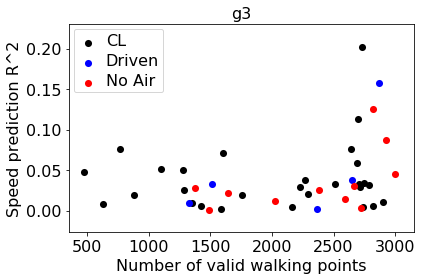

In [13]:
def plot_speed_prediction(key, ax):

    n_valids = np.array([r.n_valid for r in rslts_rgr[key]])
    r2s = np.array([r.r2 for r in rslts_rgr[key]])

    ax.scatter(n_valids[closed_mask], r2s[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    ax.scatter(n_valids[driven_mask], r2s[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    ax.scatter(n_valids[no_air_mask], r2s[no_air_mask], s=50, c=c_dict['no_air'], lw=0)

    ax.set_xlabel('Number of valid walking points')
    ax.set_ylabel('Speed prediction R^2')
    ax.set_title(key)
    ax.legend(['CL', 'Driven', 'No Air'], loc='best')

    set_font_size(ax, 16)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_speed_prediction('g3', ax)

In [14]:
# make dataframe
df_data = []
for tr_ctr, trial in enumerate(trials):
    df_data.append({
        'Trial': trial.name,
        'Expt': trial.expt,
        'Walking Fraction': rslts_clf['g3'][tr_ctr].walk_frac,
        'State Prediction': rslts_clf['g3'][tr_ctr].acc,
        'Speed Prediction': rslts_rgr['g3'][tr_ctr].r2,
    })
    
df = pd.DataFrame(df_data, columns=['Trial', 'Expt', 'Walking Fraction', 'State Prediction', 'Speed Prediction'])
        
df.round(3)

,Trial,Expt,Walking Fraction,State Prediction,Speed Prediction
0,20170310.Fly2.6,closed_loop,0.999,0.999,0.011
1,20170310.Fly3.1,closed_loop,0.991,0.991,0.030
2,20170310.Fly3.2,closed_loop,0.988,0.988,0.033
3,20170313.Fly1.1,closed_loop,0.451,0.862,0.076
4,20170313.Fly1.2,closed_loop,0.812,0.884,0.002
5,20170313.Fly1.3,closed_loop,0.880,0.926,0.019
6,20170313.Fly1.4,closed_loop,0.963,0.963,0.004
7,20170313.Fly1.8,closed_loop,0.936,0.937,0.029
8,20170313.Fly3.1,closed_loop,0.774,0.848,0.005
9,20170313.Fly3.2,closed_loop,0.938,0.973,0.037


In [15]:
df.corr()

,Walking Fraction,State Prediction,Speed Prediction
Walking Fraction,1.000000,0.580784,0.161462
State Prediction,0.580784,1.000000,0.200637
Speed Prediction,0.161462,0.200637,1.000000


### Example trial with relatively high G3-walking speed prediction (20170330.Fly1.1)

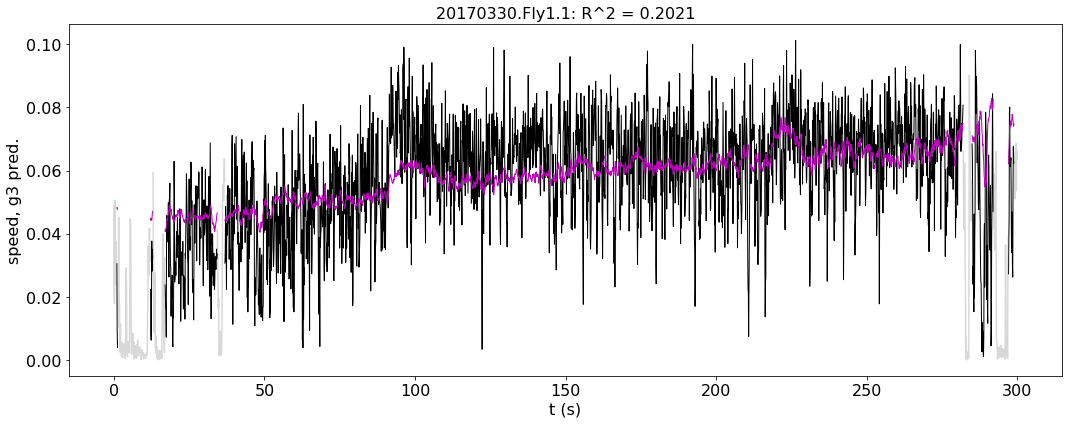

In [16]:
ax = plot_example_speed_prediction('20170330.Fly1.1', 'g3')

### Another example trial with relatively high G3-walking speed prediction (20170428.Fly2.4)

(160, 200)

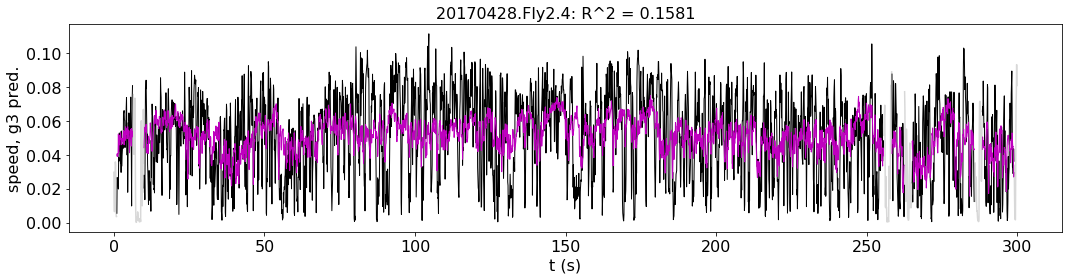

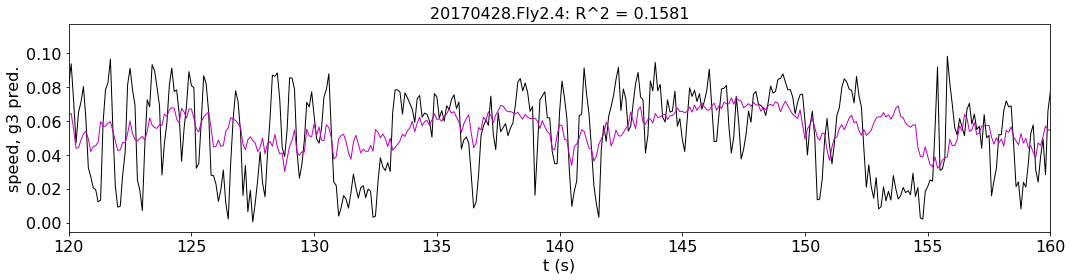

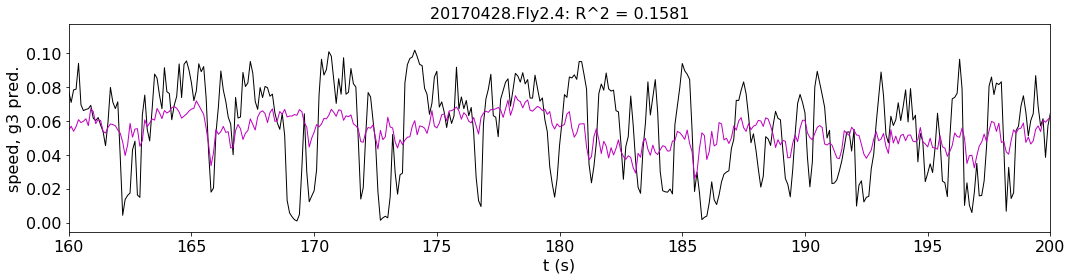

In [17]:
plot_example_speed_prediction('20170428.Fly2.4', 'g3', fig_size=(15, 4))
ax = plot_example_speed_prediction('20170428.Fly2.4', 'g3', fig_size=(15, 4))
ax.set_xlim(120, 160)
ax = plot_example_speed_prediction('20170428.Fly2.4', 'g3', fig_size=(15, 4))
ax.set_xlim(160, 200)

For this trial it seems like the G3 speed prediction may slightly follow some of the large-scale speed fluctuations. Note, however, that this does not appear to be the case for trial "20170428.Fly1.1", which also has many large-scale speed fluctuations during its walking state. If anything, however, it appears to be a very slight effect...

# Compare G3 state classification and speed prediction to that using other compartments

In [18]:
for key in ['g2', 'g4', 'g5']:
    rslts_clf[key] = [lin_fit.classify_states(trial, preds[key], WINDOWS[key]) for trial in trials]
    rslts_rgr[key] = [predict_speeds(trial, preds[key], WINDOWS[key]) for trial in trials]

/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if valid == 'all':
/Users/rkp/Dropbox/Repositories/mushroom_mushroom/lin_fit.py:145: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif valid == 'none':


### State classification accuracy

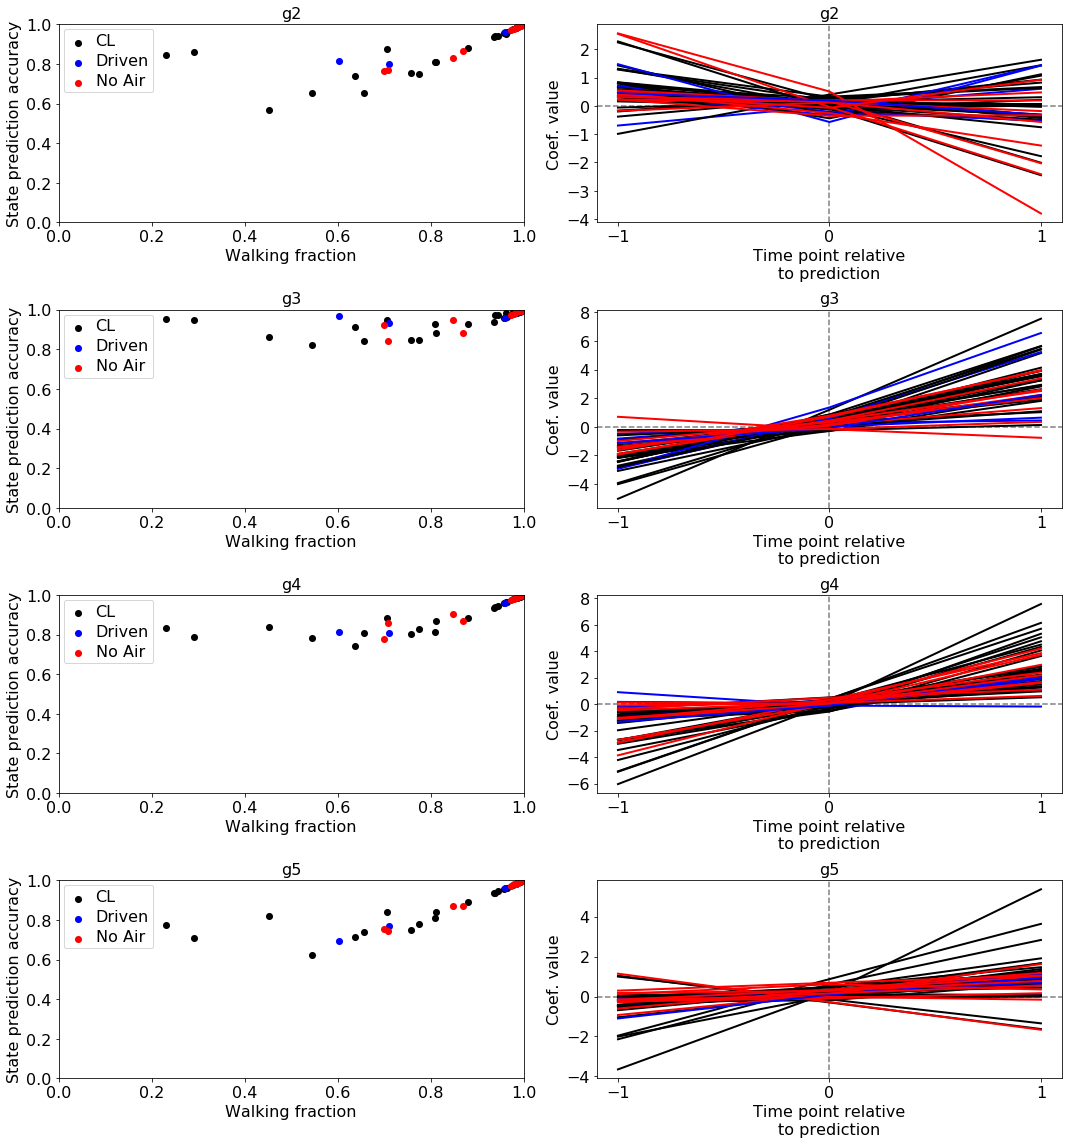

In [19]:
# plot accuracy vs. fraction of time spent walking, and G3S coefs
fig, axs = plt.subplots(4, 2, figsize=(15, 16), tight_layout=True)

keys = ['g2', 'g3', 'g4', 'g5']
coefs = ['g2s', 'g3s', 'g4s', 'g5s']

for key, coef, ax_row in zip(keys, coefs, axs):
    plot_state_classifications(key, coef, ax_row)

Here we see that while G3 indeed contains the best information for classification, G4 also classifies states reasonably well, as do the other two compartments for several trials.

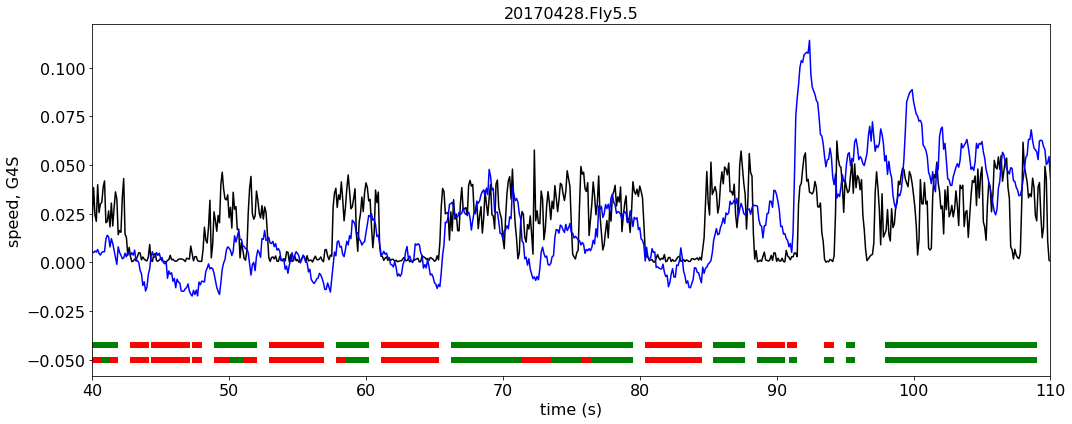

In [20]:
EXAMPLE = '20170428.Fly5.5'
LINE_YS = [-0.0425, -0.05]
LW = 6

# plot example trial's walking speed, G3S, true state labels, and predicted state labels
trial_idx = [trial.name for trial in trials].index(EXAMPLE)
trial_ex = trials[trial_idx]
rslt_ex = rslts_clf['g4'][trial_idx]

fig, ax = plt.subplots(1, 1, figsize=(15, 6), tight_layout=True)

ts = trial_ex.dl.t
speed = trial_ex.dl.speed
G4S = trial_ex.dl.g4s

# normalize G4S to be plottable atop speed
G4S -= G4S.mean()
G4S /= G4S.std()
G4S *= speed.std()
G4S += speed.mean()

ax.plot(ts, speed, color='k', lw=1.5)
ax.plot(ts, G4S, color='b', lw=1.5)

# plot true state labels, predicted state labels, and 
states_p = np.repeat(np.nan, len(ts))
states_p[rslt_ex.states == 'P'] = LINE_YS[0]
states_w = np.repeat(np.nan, len(ts))
states_w[rslt_ex.states == 'W'] = LINE_YS[0]

states_p_pred = np.repeat(np.nan, len(ts))
states_p_pred[rslt_ex.states_pred == 'P'] = LINE_YS[1]
states_w_pred = np.repeat(np.nan, len(ts))
states_w_pred[rslt_ex.states_pred == 'W'] = LINE_YS[1]

ax.plot(ts, states_p, lw=LW, color='r')
ax.plot(ts, states_w, lw=LW, color='g')

ax.plot(ts, states_p_pred, lw=LW, color='r')
ax.plot(ts, states_w_pred, lw=LW, color='g')

ax.set_xlim(40, 110)

ax.set_xlabel('time (s)')
ax.set_ylabel('speed, G4S')
ax.set_title(EXAMPLE)

set_font_size(ax, 16)

### Speed R^2 vs. n_valid using different predictors

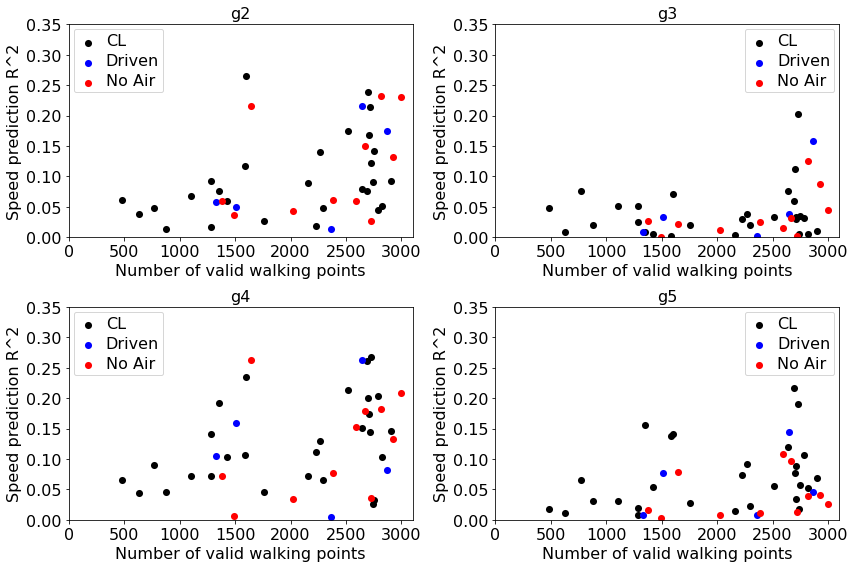

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
    
for key, ax in zip(['g2', 'g3', 'g4', 'g5'], axs.flatten()):
    plot_speed_prediction(key, ax)
    ax.set_xlim(0, 3100)
    ax.set_ylim(0, 0.35)

# Show table of trials and R^2s

In [22]:
import pandas as pd

# make dataframe
df_data = []
for tr_ctr, trial in enumerate(trials):
    df_data.append({
        'Trial': trial.name,
        'Expt': trial.expt,
        'G2 (st.)': rslts_clf['g2'][tr_ctr].acc,
        'G3 (st.)': rslts_clf['g3'][tr_ctr].acc,
        'G4 (st.)': rslts_clf['g4'][tr_ctr].acc,
        'G5 (st.)': rslts_clf['g5'][tr_ctr].acc,
        'G2 (sp.)': rslts_rgr['g2'][tr_ctr].r2,
        'G3 (sp.)': rslts_rgr['g3'][tr_ctr].r2,
        'G4 (sp.)': rslts_rgr['g4'][tr_ctr].r2,
        'G5 (sp.)': rslts_rgr['g5'][tr_ctr].r2,
    })

columns=[
    'Trial', 'Expt',
    'G2 (st.)', 'G3 (st.)', 'G4 (st.)', 'G5 (st.)',
    'G2 (sp.)', 'G3 (sp.)', 'G4 (sp.)', 'G5 (sp.)',
]
df = pd.DataFrame(df_data, columns=columns)
        
df.round(3)

,Trial,Expt,G2 (st.),G3 (st.),G4 (st.),G5 (st.),G2 (sp.),G3 (sp.),G4 (sp.),G5 (sp.)
0,20170310.Fly2.6,closed_loop,0.999,0.999,0.999,0.999,0.092,0.011,0.146,0.069
1,20170310.Fly3.1,closed_loop,0.991,0.991,0.991,0.991,0.215,0.030,0.145,0.088
2,20170310.Fly3.2,closed_loop,0.988,0.988,0.988,0.988,0.168,0.033,0.173,0.034
3,20170313.Fly1.1,closed_loop,0.566,0.862,0.839,0.821,0.048,0.076,0.090,0.066
4,20170313.Fly1.2,closed_loop,0.812,0.884,0.869,0.840,0.116,0.002,0.106,0.137
5,20170313.Fly1.3,closed_loop,0.880,0.926,0.882,0.892,0.026,0.019,0.046,0.028
6,20170313.Fly1.4,closed_loop,0.963,0.963,0.963,0.963,0.090,0.004,0.072,0.015
7,20170313.Fly1.8,closed_loop,0.936,0.937,0.936,0.936,0.019,0.029,0.111,0.074
8,20170313.Fly3.1,closed_loop,0.751,0.848,0.829,0.781,0.059,0.005,0.103,0.055
9,20170313.Fly3.2,closed_loop,0.943,0.973,0.938,0.938,0.141,0.037,0.129,0.092


In [23]:
save_table(os.path.join(L.TABLE_DIR, 'g3_state_speed.csv'), df)

### Correlation matrix

In [24]:
df.corr()

,G2 (st.),G3 (st.),G4 (st.),G5 (st.),G2 (sp.),G3 (sp.),G4 (sp.),G5 (sp.)
G2 (st.),1.000000,0.894961,0.890030,0.883575,0.345359,0.141127,0.268031,0.220843
G3 (st.),0.894961,1.000000,0.780387,0.791505,0.298812,0.200637,0.229329,0.202475
G4 (st.),0.890030,0.780387,1.000000,0.969112,0.338114,0.232557,0.255316,0.260194
G5 (st.),0.883575,0.791505,0.969112,1.000000,0.374549,0.239188,0.287056,0.290903
G2 (sp.),0.345359,0.298812,0.338114,0.374549,1.000000,0.444854,0.639880,0.319462
G3 (sp.),0.141127,0.200637,0.232557,0.239188,0.444854,1.000000,0.426534,0.347729
G4 (sp.),0.268031,0.229329,0.255316,0.287056,0.639880,0.426534,1.000000,0.740530
G5 (sp.),0.220843,0.202475,0.260194,0.290903,0.319462,0.347729,0.740530,1.000000


Here we basically see weak to strong positive correlations between all pairs of predictive measures regarding speed. This suggests that certain trial simply have more predictable speeds than others.

In [25]:
df.mean()

G2 (st.)    0.894773
G3 (st.)    0.948090
G4 (st.)    0.915466
G5 (st.)    0.893878
G2 (sp.)    0.100635
G3 (sp.)    0.039576
G4 (sp.)    0.124286
G5 (sp.)    0.061763
dtype: float64

Here we see that G3 is the best (though only slightly) predictor of walking state, whereas G4 is by far the best predictor of walking speed, although the median predictive value is still quite low.

### Show trials with high G4-speed R2

(100, 200)

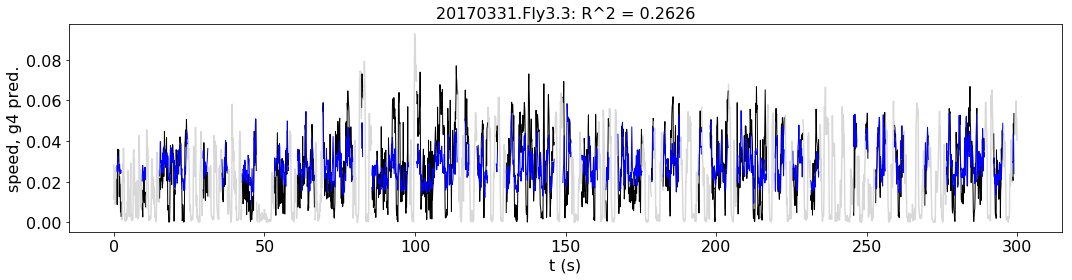

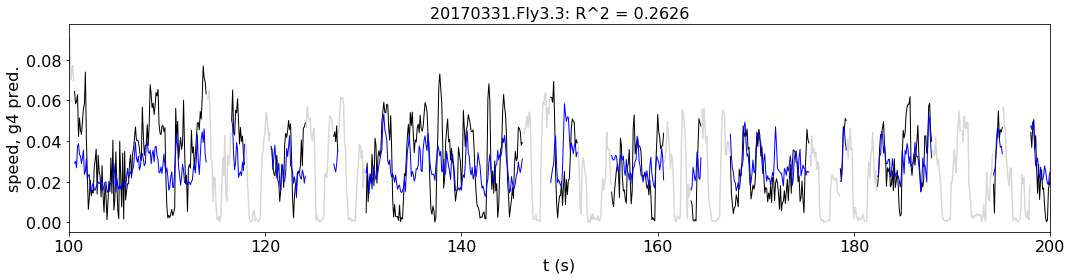

In [26]:
ax = plot_example_speed_prediction('20170331.Fly3.3', 'g4', fig_size=(15, 4), color='b')
ax = plot_example_speed_prediction('20170331.Fly3.3', 'g4', fig_size=(15, 4), color='b')
ax.set_xlim(100, 200)

(100, 200)

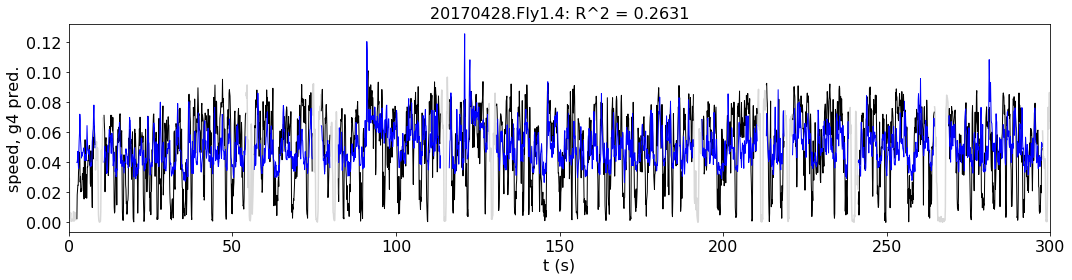

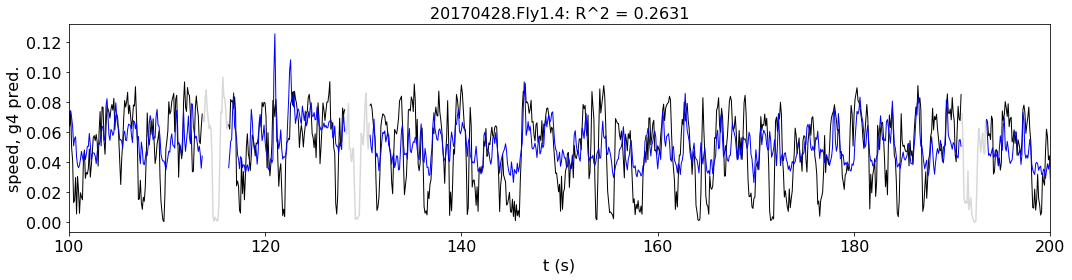

In [27]:
ax = plot_example_speed_prediction('20170428.Fly1.4', 'g4', fig_size=(15, 4), color='b')
ax.set_xlim(0, 300)
ax = plot_example_speed_prediction('20170428.Fly1.4', 'g4', fig_size=(15, 4), color='b')
ax.set_xlim(100, 200)

# Relationships between predictiveness of different compartments

Finally, we ask whether, say, trials with good G3 state classification tend to have poor G4 state classification, etc. 

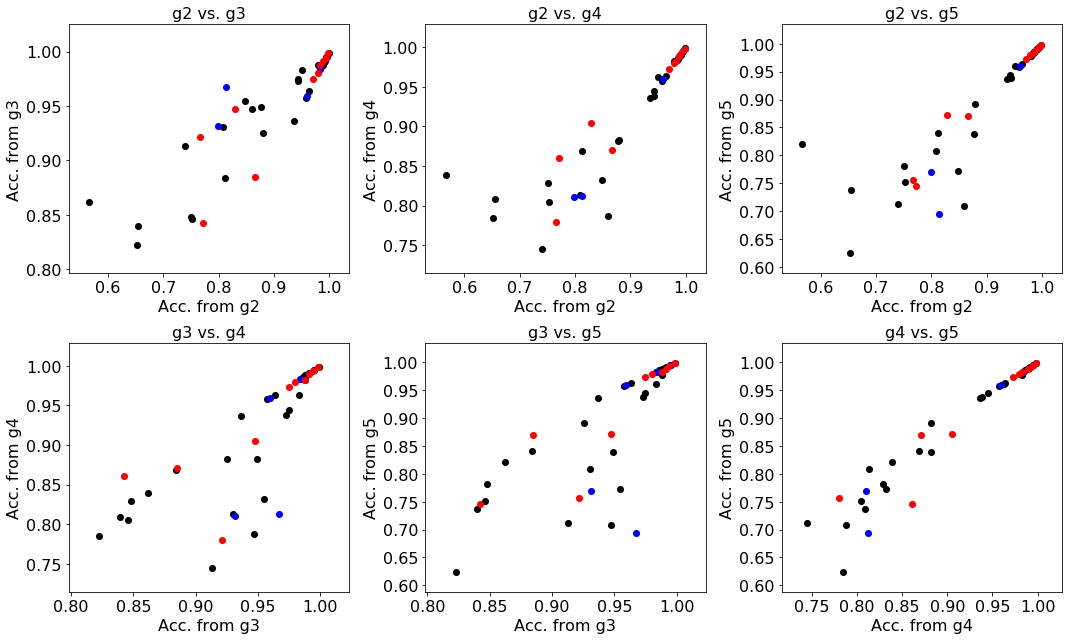

In [28]:
pairs = [('g2', 'g3'), ('g2', 'g4'), ('g2', 'g5'), ('g3', 'g4'), ('g3', 'g5'), ('g4', 'g5')]

# plot relationships between state classification accuracies
fig, axs = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)

for (key_0, key_1), ax in zip(pairs, axs.flatten()):
    accs_0 = np.array([r.acc for r in rslts_clf[key_0]])
    accs_1 = np.array([r.acc for r in rslts_clf[key_1]])
    
    ax.scatter(accs_0[closed_mask], accs_1[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    ax.scatter(accs_0[driven_mask], accs_1[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    ax.scatter(accs_0[no_air_mask], accs_1[no_air_mask], s=50, c=c_dict['no_air'], lw=0)
    
    ax.set_xlabel('Acc. from {}'.format(key_0))
    ax.set_ylabel('Acc. from {}'.format(key_1))
    ax.set_title('{} vs. {}'.format(key_0, key_1))
    
    set_font_size(ax, 16)

Here we see strong positive correlations among accuracies from all pairs of predictors. This suggests that if a trial's states can be well predicted from one compartment, they're also likely to be well predicted from another compartment, suggesting that certain trials are just more predictable in general.

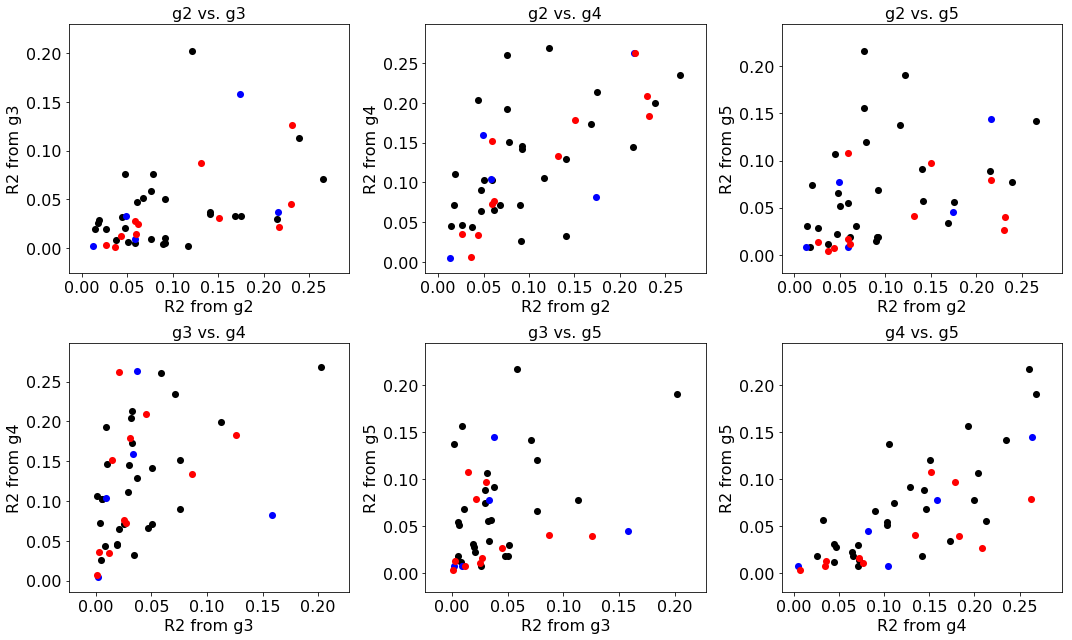

In [29]:
pairs = [('g2', 'g3'), ('g2', 'g4'), ('g2', 'g5'), ('g3', 'g4'), ('g3', 'g5'), ('g4', 'g5')]

# plot relationships between speed prediction r2s
fig, axs = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)

for (key_0, key_1), ax in zip(pairs, axs.flatten()):
    r2s_0 = np.array([r.r2 for r in rslts_rgr[key_0]])
    r2s_1 = np.array([r.r2 for r in rslts_rgr[key_1]])
    
    ax.scatter(r2s_0[closed_mask], r2s_1[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    ax.scatter(r2s_0[driven_mask], r2s_1[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    ax.scatter(r2s_0[no_air_mask], r2s_1[no_air_mask], s=50, c=c_dict['no_air'], lw=0)
    
    ax.set_xlabel('R2 from {}'.format(key_0))
    ax.set_ylabel('R2 from {}'.format(key_1))
    ax.set_title('{} vs. {}'.format(key_0, key_1))
    
    set_font_size(ax, 16)

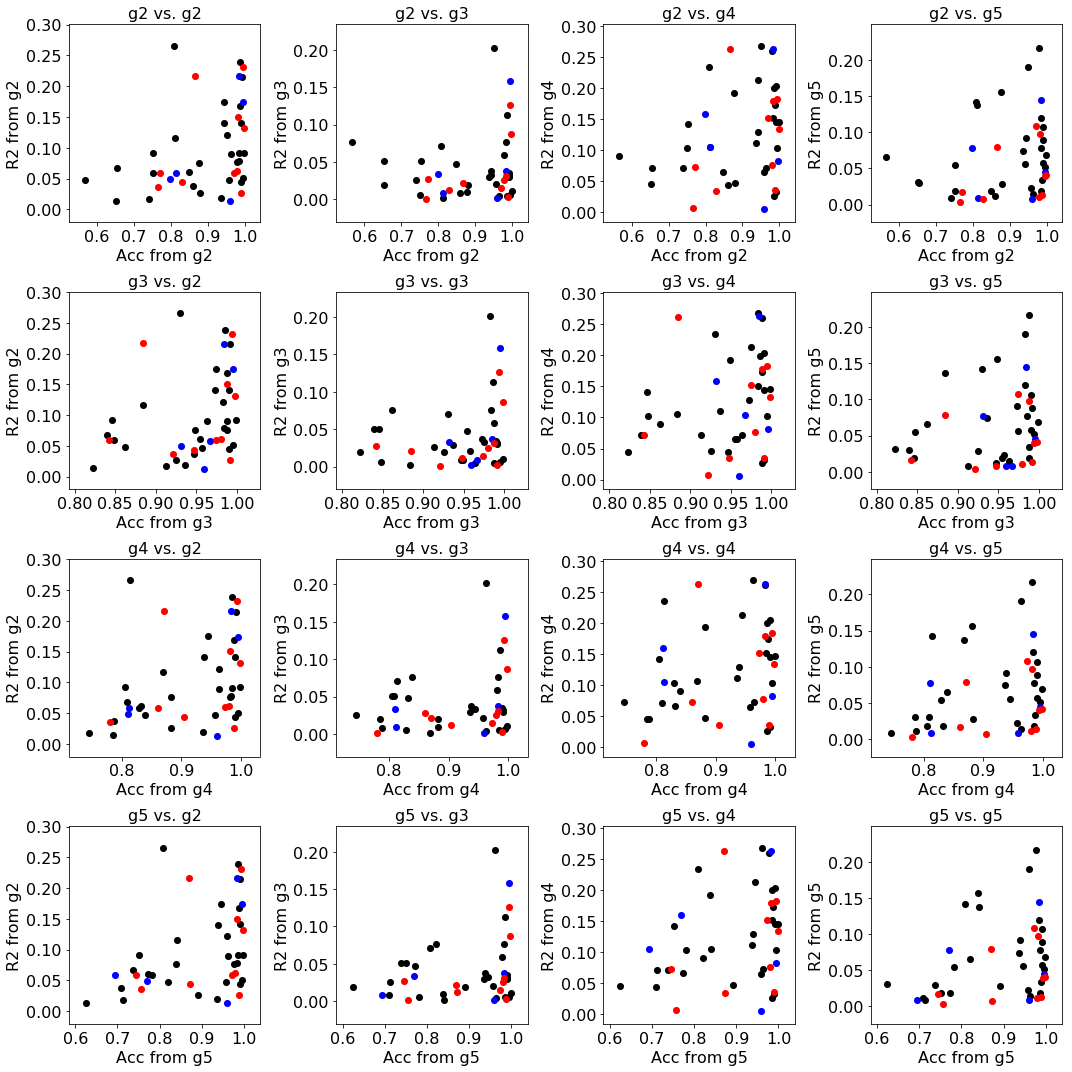

In [30]:
from itertools import product as cproduct

pairs = cproduct(keys, keys)

# plot relationships between state prediction from one compartment and speed prediction from another
fig, axs = plt.subplots(4, 4, figsize=(15, 15), tight_layout=True)

for (key_0, key_1), ax in zip(pairs, axs.flatten()):
    accs = np.array([r.acc for r in rslts_clf[key_0]])
    r2s = np.array([r.r2 for r in rslts_rgr[key_1]])
    
    ax.scatter(accs[closed_mask], r2s[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    ax.scatter(accs[driven_mask], r2s[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    ax.scatter(accs[no_air_mask], r2s[no_air_mask], s=50, c=c_dict['no_air'], lw=0)
    
    ax.set_xlabel('Acc from {}'.format(key_0))
    ax.set_ylabel('R2 from {}'.format(key_1))
    ax.set_title('{} vs. {}'.format(key_0, key_1))
    
    set_font_size(ax, 16)